In [1]:
import time
print(time.ctime())
start_time = time.time()

Mon Apr  4 14:51:02 2022


In [2]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD

Init Plugin
Init Graph Optimizer
Init Kernel


In [4]:
#some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [5]:
# load in the data
input_texts = []
target_texts = []
for line in open('robert_frost.txt'):
    line = line.strip()
    if not line:
        continue
    
    input_line = '<sos> '+line
    target_line = line+' <eos>'
    
    input_texts.append(input_line)
    target_texts.append(target_line)
    
all_lines = input_texts + target_texts

#convert the sentences (string) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)
print(input_sequences[0])
print(target_sequences[0])

[1, 104, 537, 538, 9, 7, 539, 540]
[104, 537, 538, 9, 7, 539, 540, 2]


In [6]:
#find the max sequence length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print("Maximum seq length from the input_sequences:", max_sequence_length_from_data)

Maximum seq length from the input_sequences: 12


In [7]:
#get word -> integer mapping
word2idx = tokenizer.word_index
print(f"Found {len(word2idx)} unique tokens")

Found 3056 unique tokens


In [8]:
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

In [9]:
#pad sequence so that we get NxT matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding="post")
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding="post")
print('Shape of data tensor: ', input_sequences.shape)
print(type(input_sequences))
print(input_sequences)

Shape of data tensor:  (1436, 12)
<class 'numpy.ndarray'>
[[  1 104 537 ...   0   0   0]
 [  1   5 541 ...   0   0   0]
 [  1   5  27 ...   0   0   0]
 ...
 [  1  53 564 ...   0   0   0]
 [  1  69 438 ... 733   0   0]
 [  1   4  75 ...   0   0   0]]


In [10]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../../Natural Language Processing with Deep Learning in Python/2. Beginner\'s Corner Working with Word Vectors/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [11]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
          # words not found in embedding index will be all zeros.
          embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [12]:
#one-hot the target (can't use sparse entropy when the targets are sequences)
one_hot_targets = np.zeros((len(target_sequences), max_sequence_length, num_words)) #mind the order of dimensions
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word>0:
            one_hot_targets[i, t, word] = 1

In [13]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)

In [14]:
print('Building model...')

#create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length))
initial_h = Input(shape=(LATENT_DIM, ))
initial_c = Input(shape=(LATENT_DIM, ))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) #don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  #optimizer=opt,
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

Building model...
Metal device set to: Apple M1


2022-04-04 14:51:07.124882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-04 14:51:07.124974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Training model...


2022-04-04 14:51:07.346147: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-04 14:51:07.346300: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-04 14:51:14.467916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-04 14:51:14.551925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-04 14:51:14.641924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-04 14:51:15.344426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-04 14:51:15.382067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:11

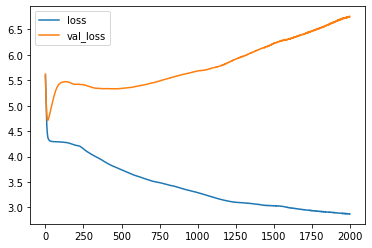

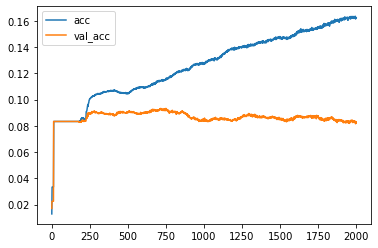

In [15]:
print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT,
  verbose=0
)

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [16]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [17]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [18]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

# generate a 4 line poem
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

2022-04-04 17:29:17.257163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-04 17:29:17.280335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


don't been must be cottages him scribble,
but if empty. just fair, down and the floor on other, according
the darkest out the door the village, leak thorn.) stir.
the mountain let they very found eyes, have mean him little, (a
---generate another? [Y/n]---y
read snow in where a house still rattling stillgoing torrence she's after
and on take one nights out. out,
(where your well oracle you're
it's but we're the north
---generate another? [Y/n]---n


In [19]:
print(f"{(time.time()-start_time)/60:.2f} mins")

182.17 mins
